In [2]:
# 必要ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
from tqdm.notebook import tqdm

# PyTorch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

# warning表示off
import warnings
warnings.simplefilter('ignore')
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14
# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)
# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True
# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [3]:
# GPUチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))
# 結果確認
print(n_output)

10


### データ準備

In [5]:
# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# テストデータ用: 
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [6]:
data_root = './ignore_dir/data'

# 訓練データの取得
train_set = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform_train)

# テストデータの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, 
    batch_size = batch_size, shuffle = True)

# テスト用データローダー
# テスト時にシャッフルは不要
test_loader = DataLoader(test_set,  
    batch_size = batch_size, shuffle = False) 

In [8]:
# 乱数初期化
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_seed()

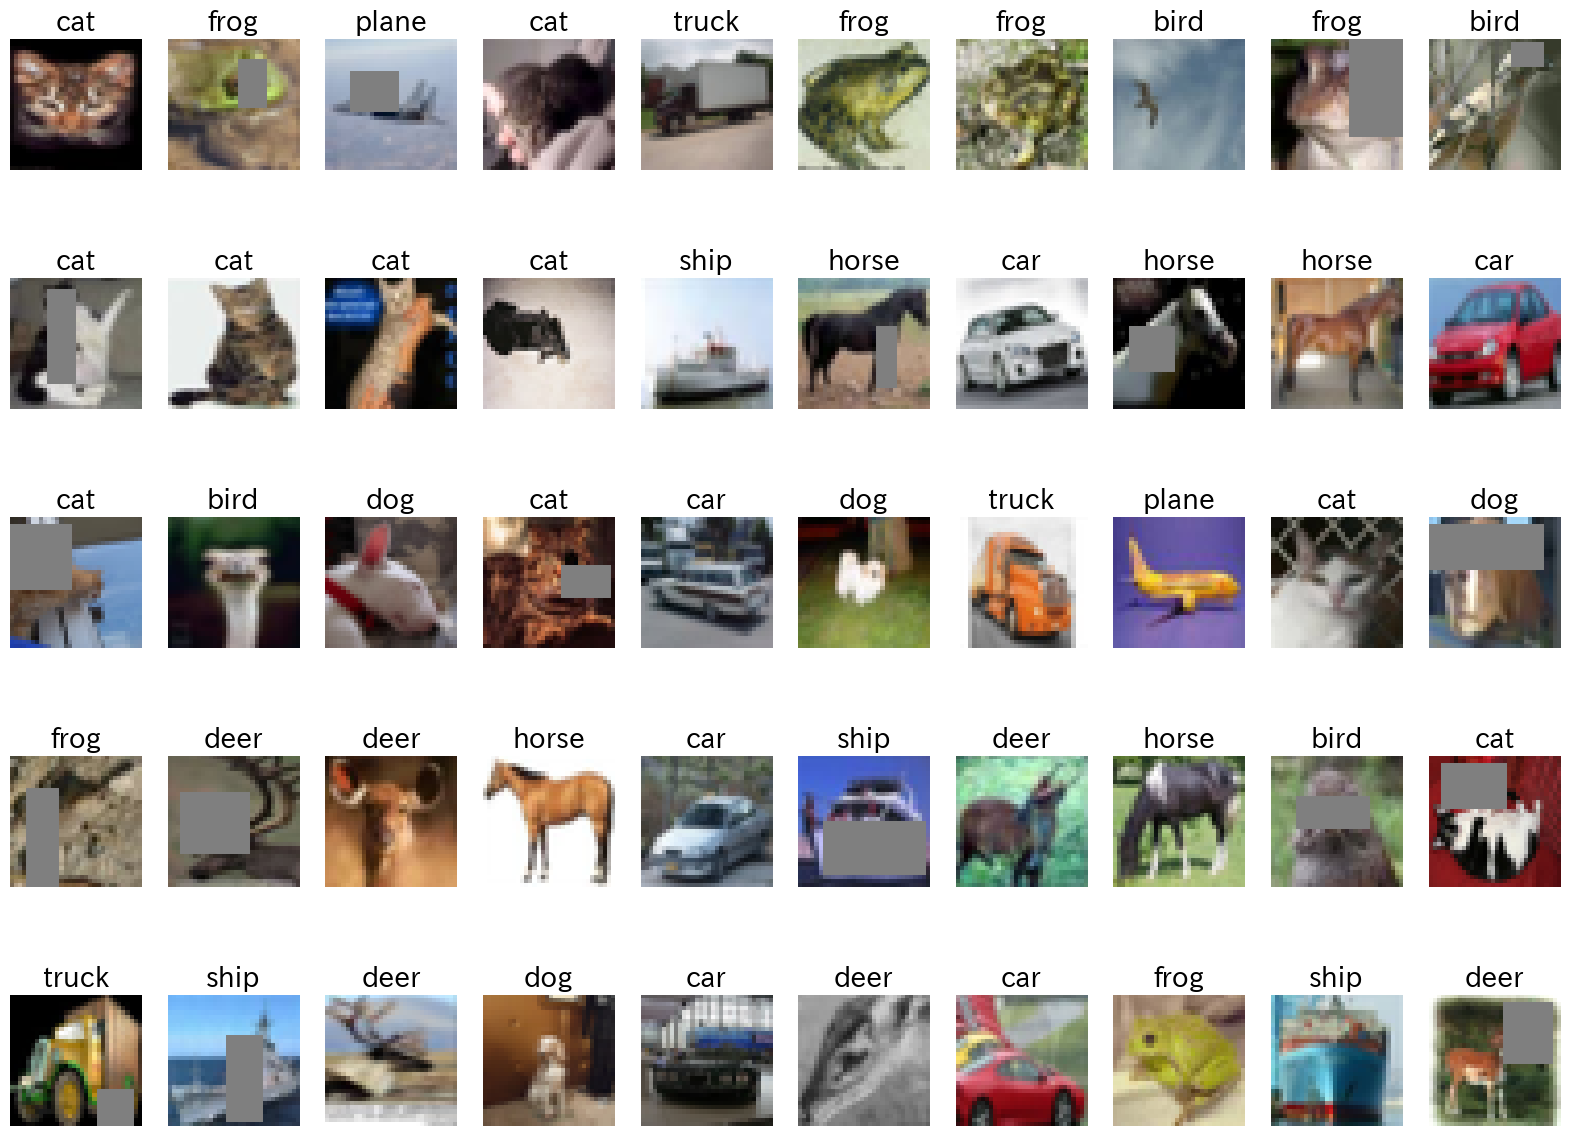

In [9]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()
show_images_labels(train_loader, classes, None, None)

In [ ]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,     # 畳み込み
            self.bn1,       # バッチノーマライゼーション
            self.relu,      # 活性化関数
            self.conv2,     # 畳み込み
            self.bn2,       # バッチノーマライゼーション
            self.relu,      # 活性化関数
            self.maxpool,   # プーリング
            self.dropout1,  # ドロップアウト
            self.conv3,     # 畳み込み
            self.bn3,       # バッチノーマライゼーション
            self.relu,      # 活性化関数
            self.conv4,     # 畳み込み
            self.bn4,       # バッチノーマライゼーション
            self.relu,      # 活性化関数
            self.maxpool,   # プーリング
            self.dropout2,  # ドロップアウト
            self.conv5,     # 畳み込み
            self.bn5,       # バッチノーマライゼーション
            self.relu,      # 活性化関数
            self.conv6,     # 畳み込み
            self.bn6,       # バッチノーマライゼーション
            self.relu,      # 活性化関数
            self.maxpool,   # プーリング
            self.dropout3,  # ドロップアウト
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)
# 交差エントロピー誤差関数
criterion = nn.CrossEntropyLoss()
# Adam最適化
optimizer = optim.Adam(net.parameters())
# 履歴保存用
history = np.zeros((0, 5))

## 学習

In [11]:
num_epochs = 100

# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
    
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size 
            n_train_acc += (predicted == labels).sum().item() 

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)
 
            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()
    
        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

history = fit(net, optimizer, criterion, num_epochs, 
       train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.59071 acc: 0.41010 val_loss: 1.27110, val_acc: 0.53560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.25364 acc: 0.54834 val_loss: 0.96222, val_acc: 0.65070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/100], loss: 1.12101 acc: 0.60216 val_loss: 0.88943, val_acc: 0.68320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/100], loss: 1.04203 acc: 0.63344 val_loss: 0.78367, val_acc: 0.72240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.98435 acc: 0.65474 val_loss: 0.77386, val_acc: 0.73110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.93577 acc: 0.67600 val_loss: 0.72345, val_acc: 0.74510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.89838 acc: 0.69014 val_loss: 0.69116, val_acc: 0.76010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.86055 acc: 0.70330 val_loss: 0.66190, val_acc: 0.76970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.83345 acc: 0.71506 val_loss: 0.62575, val_acc: 0.78560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.80118 acc: 0.72654 val_loss: 0.60856, val_acc: 0.78780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.78559 acc: 0.73572 val_loss: 0.59306, val_acc: 0.79400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.76552 acc: 0.74106 val_loss: 0.57665, val_acc: 0.80460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.73973 acc: 0.74988 val_loss: 0.51964, val_acc: 0.82060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.71663 acc: 0.75642 val_loss: 0.50173, val_acc: 0.82730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.70608 acc: 0.76138 val_loss: 0.55261, val_acc: 0.81640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.69031 acc: 0.76662 val_loss: 0.51516, val_acc: 0.82910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.67554 acc: 0.77252 val_loss: 0.49501, val_acc: 0.83400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.66350 acc: 0.77754 val_loss: 0.48160, val_acc: 0.83900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.64761 acc: 0.77862 val_loss: 0.48664, val_acc: 0.83730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.64210 acc: 0.78416 val_loss: 0.51014, val_acc: 0.82730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.62874 acc: 0.79080 val_loss: 0.48286, val_acc: 0.83990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.61975 acc: 0.79288 val_loss: 0.45269, val_acc: 0.84840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.60766 acc: 0.79480 val_loss: 0.48329, val_acc: 0.84200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.59722 acc: 0.79914 val_loss: 0.46650, val_acc: 0.84690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.59720 acc: 0.80050 val_loss: 0.45273, val_acc: 0.85100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.59080 acc: 0.80332 val_loss: 0.43083, val_acc: 0.85520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.58146 acc: 0.80534 val_loss: 0.44004, val_acc: 0.85530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.57304 acc: 0.80712 val_loss: 0.46053, val_acc: 0.84630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.56439 acc: 0.80898 val_loss: 0.47616, val_acc: 0.84530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.56065 acc: 0.81246 val_loss: 0.43793, val_acc: 0.85690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.54893 acc: 0.81580 val_loss: 0.41549, val_acc: 0.85940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.54821 acc: 0.81382 val_loss: 0.42697, val_acc: 0.85950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.53996 acc: 0.81770 val_loss: 0.44923, val_acc: 0.85140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.53248 acc: 0.82122 val_loss: 0.41801, val_acc: 0.86230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.52847 acc: 0.82330 val_loss: 0.41834, val_acc: 0.86420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.52090 acc: 0.82576 val_loss: 0.39905, val_acc: 0.86570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.51361 acc: 0.82658 val_loss: 0.40560, val_acc: 0.86710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.51484 acc: 0.82838 val_loss: 0.42577, val_acc: 0.86390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.50871 acc: 0.82826 val_loss: 0.41642, val_acc: 0.86100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.50479 acc: 0.82936 val_loss: 0.41545, val_acc: 0.86360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.50414 acc: 0.83120 val_loss: 0.39582, val_acc: 0.87370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.49843 acc: 0.83330 val_loss: 0.39829, val_acc: 0.86490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.49688 acc: 0.83122 val_loss: 0.39907, val_acc: 0.86920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.49124 acc: 0.83434 val_loss: 0.37867, val_acc: 0.87320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.49205 acc: 0.83348 val_loss: 0.38898, val_acc: 0.87250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.48166 acc: 0.83742 val_loss: 0.40257, val_acc: 0.86520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.47580 acc: 0.83956 val_loss: 0.39915, val_acc: 0.87130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.47287 acc: 0.83958 val_loss: 0.40676, val_acc: 0.86980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.47537 acc: 0.84032 val_loss: 0.38336, val_acc: 0.87470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.46831 acc: 0.84242 val_loss: 0.39991, val_acc: 0.86700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.46860 acc: 0.83950 val_loss: 0.38050, val_acc: 0.87230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.46650 acc: 0.84236 val_loss: 0.38288, val_acc: 0.87500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.46003 acc: 0.84354 val_loss: 0.38406, val_acc: 0.87650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.45628 acc: 0.84622 val_loss: 0.38499, val_acc: 0.87570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.45560 acc: 0.84666 val_loss: 0.39007, val_acc: 0.87290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.45813 acc: 0.84490 val_loss: 0.37113, val_acc: 0.87720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.44731 acc: 0.84798 val_loss: 0.37800, val_acc: 0.87700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.44796 acc: 0.84678 val_loss: 0.39140, val_acc: 0.87150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.44155 acc: 0.84964 val_loss: 0.38302, val_acc: 0.87760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.44911 acc: 0.84792 val_loss: 0.40204, val_acc: 0.87240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.44025 acc: 0.84898 val_loss: 0.35941, val_acc: 0.88270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.43283 acc: 0.85248 val_loss: 0.38142, val_acc: 0.87760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.43621 acc: 0.85022 val_loss: 0.37298, val_acc: 0.88110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.43344 acc: 0.85338 val_loss: 0.36706, val_acc: 0.88150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.43075 acc: 0.85342 val_loss: 0.38062, val_acc: 0.87670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.43291 acc: 0.85496 val_loss: 0.36522, val_acc: 0.88380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.42848 acc: 0.85308 val_loss: 0.36818, val_acc: 0.88080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.42509 acc: 0.85448 val_loss: 0.37266, val_acc: 0.88140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.42379 acc: 0.85408 val_loss: 0.35598, val_acc: 0.88310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.42241 acc: 0.85496 val_loss: 0.37227, val_acc: 0.87630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.41738 acc: 0.85650 val_loss: 0.35630, val_acc: 0.88280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.42054 acc: 0.85676 val_loss: 0.38825, val_acc: 0.87440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.41215 acc: 0.85676 val_loss: 0.39065, val_acc: 0.87510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.41522 acc: 0.85720 val_loss: 0.37134, val_acc: 0.87860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.41519 acc: 0.85794 val_loss: 0.37076, val_acc: 0.87680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.41262 acc: 0.85860 val_loss: 0.37776, val_acc: 0.87750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.41263 acc: 0.85846 val_loss: 0.37010, val_acc: 0.87920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.40647 acc: 0.86198 val_loss: 0.34590, val_acc: 0.88690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.40463 acc: 0.86230 val_loss: 0.36927, val_acc: 0.88330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.40395 acc: 0.86178 val_loss: 0.36464, val_acc: 0.88430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.40690 acc: 0.86016 val_loss: 0.36824, val_acc: 0.88430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.39878 acc: 0.86316 val_loss: 0.36570, val_acc: 0.88420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.40308 acc: 0.86326 val_loss: 0.37209, val_acc: 0.88150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.39907 acc: 0.86322 val_loss: 0.35711, val_acc: 0.88680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.39406 acc: 0.86466 val_loss: 0.35282, val_acc: 0.88460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.39768 acc: 0.86416 val_loss: 0.37045, val_acc: 0.88190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.39713 acc: 0.86380 val_loss: 0.34989, val_acc: 0.88580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.39288 acc: 0.86572 val_loss: 0.34930, val_acc: 0.88650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.38993 acc: 0.86628 val_loss: 0.34433, val_acc: 0.89030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.38854 acc: 0.86610 val_loss: 0.34772, val_acc: 0.88780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.38987 acc: 0.86634 val_loss: 0.35616, val_acc: 0.88560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.38579 acc: 0.86618 val_loss: 0.34987, val_acc: 0.88920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.38923 acc: 0.86664 val_loss: 0.36076, val_acc: 0.88760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.38505 acc: 0.86864 val_loss: 0.36618, val_acc: 0.88420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.38474 acc: 0.86886 val_loss: 0.35096, val_acc: 0.88860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.38043 acc: 0.86882 val_loss: 0.34975, val_acc: 0.88730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.38296 acc: 0.86960 val_loss: 0.35986, val_acc: 0.88680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.38335 acc: 0.86924 val_loss: 0.34904, val_acc: 0.88780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.38392 acc: 0.86800 val_loss: 0.35063, val_acc: 0.88890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.37796 acc: 0.87140 val_loss: 0.35388, val_acc: 0.89090


初期状態: 損失: 1.27110 精度: 0.53560
最終状態: 損失: 0.35388 精度: 0.89090


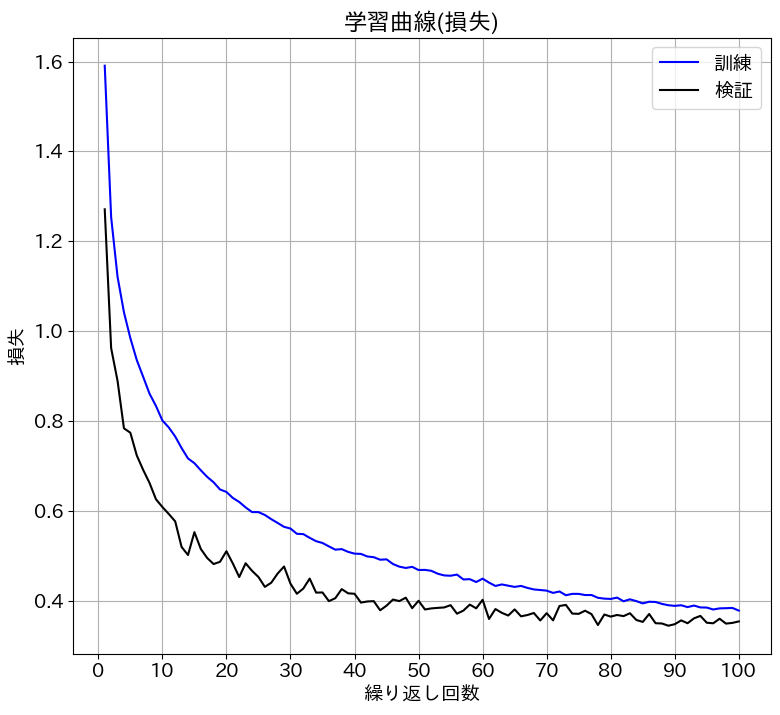

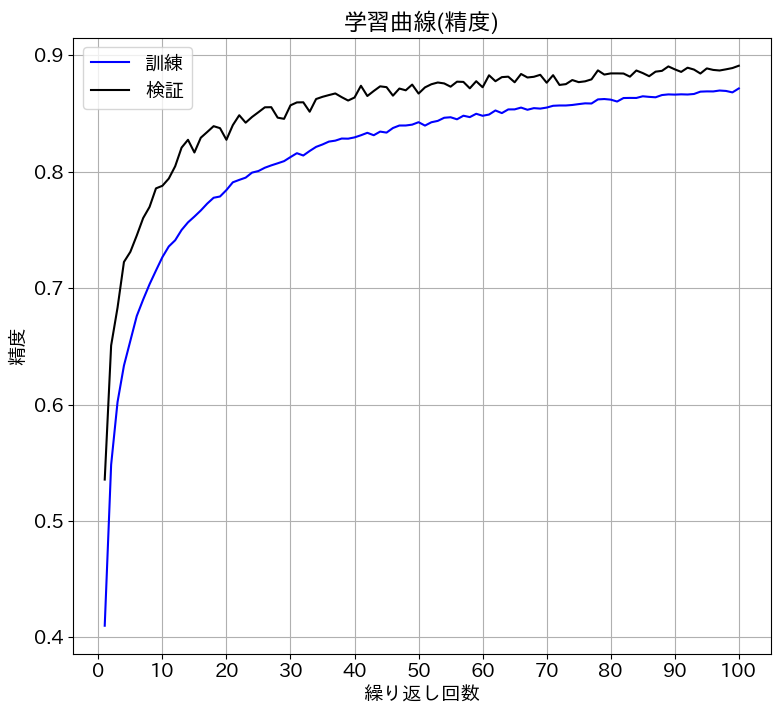

In [12]:
# 学習ログ解析
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    if num_epochs < 10:
        unit = 1
    else:
        unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

evaluate_history(history)

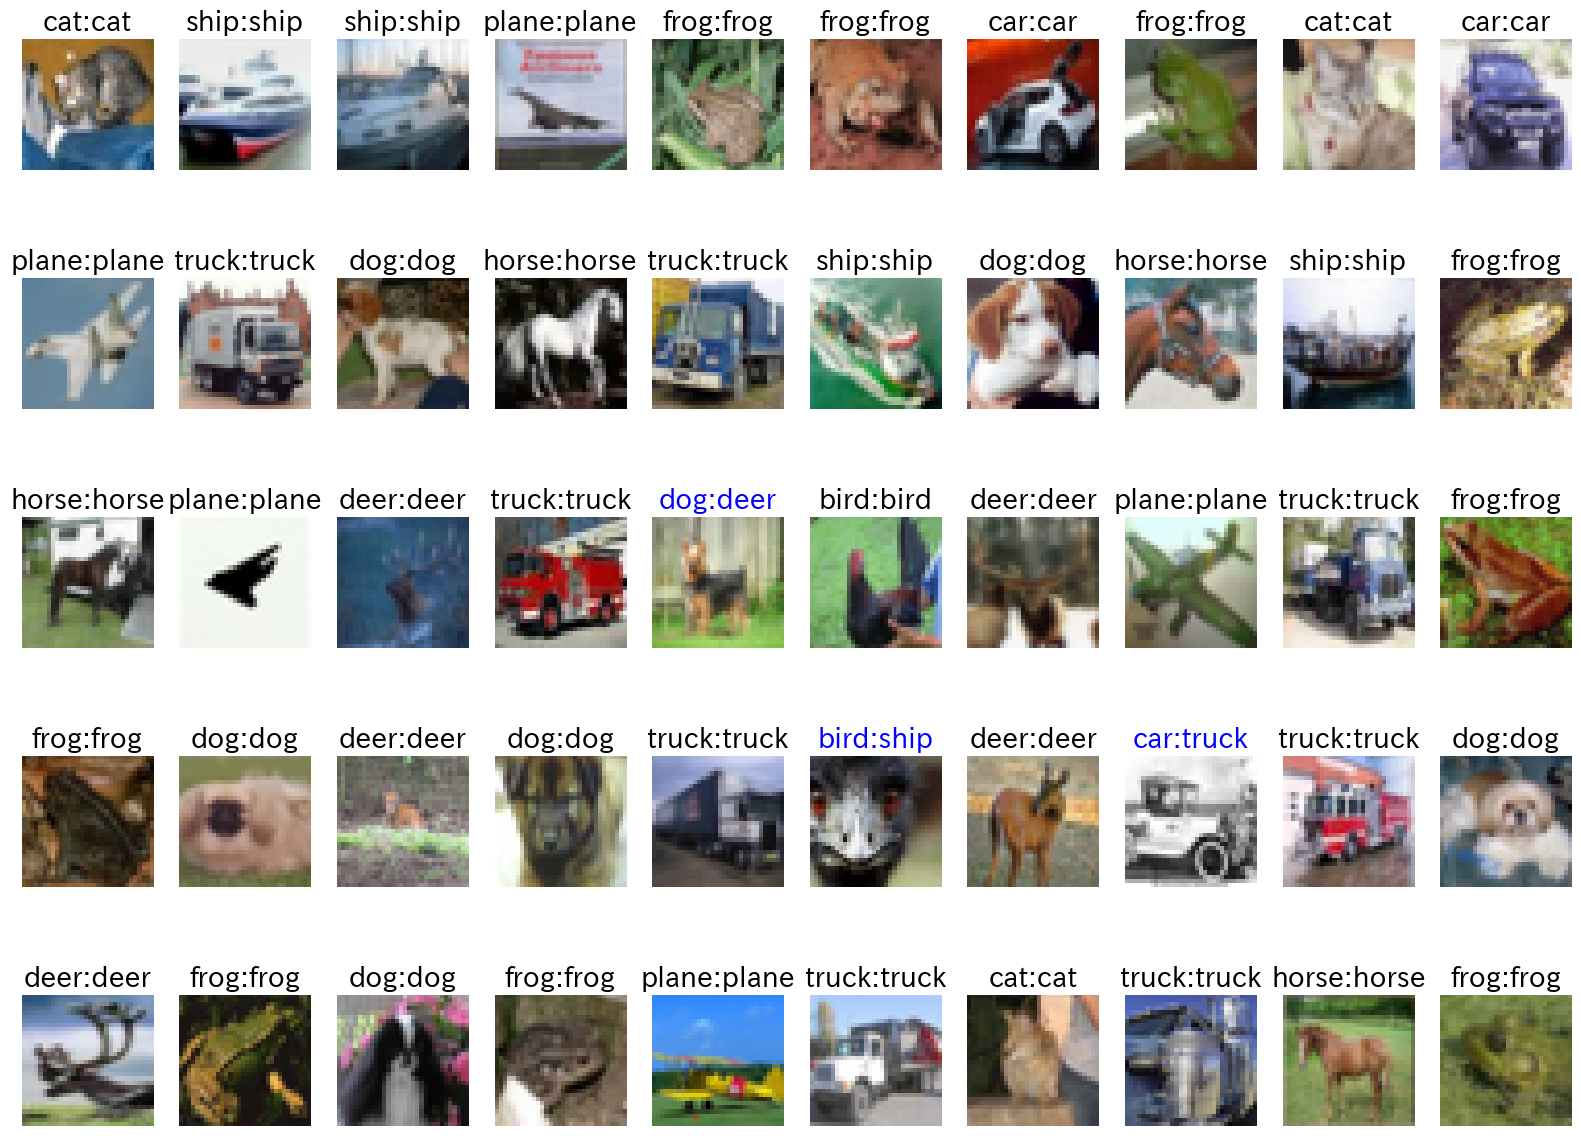

In [13]:
show_images_labels(test_loader, classes, net, device)

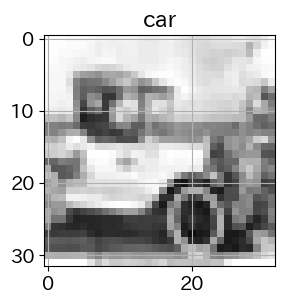

In [14]:
# 間違えた38番目のデータを抽出
for images, labels in test_loader:
    break
image = images[37]
label = labels[37]

# イメージを表示して確認
plt.figure(figsize=(3,3))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2 
plt.title(classes[label])
plt.imshow(w3)
plt.show()

In [15]:
# 予測値を取得
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

# ラベル別の確率値を表示
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
values = np.frompyfunc(lambda x: f'{x:.04f}', 1, 1)(probs_np)
names = np.array(classes)
tbl = np.array([names, values]).T
print(tbl)

[['plane' '0.0000']
 ['car' '0.3144']
 ['bird' '0.0000']
 ['cat' '0.0000']
 ['deer' '0.0000']
 ['dog' '0.0000']
 ['frog' '0.0000']
 ['horse' '0.0000']
 ['ship' '0.0000']
 ['truck' '0.6855']]
